## Dataset

In [1]:
# Download dataset
# !gdown --id 1rbVirTmc2_NZyEHnjtEqoHFPGekApc25 -O dataset.zip

In [2]:
# Download resized dataset
!gdown --id 1aFthbjHyKQWNoF-E6TdONuhY68ccnQaw -O dataset.zip

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1aFthbjHyKQWNoF-E6TdONuhY68ccnQaw
To: /content/dataset.zip
100% 3.17M/3.17M [00:00<00:00, 203MB/s]


In [3]:
import os
os.listdir("/content")

['.config', 'dataset.zip', 'sample_data']

In [4]:
# prompt: unzip "/content/dataset.zip"
!unzip /content/dataset.zip -d /content/dataset


Archive:  /content/dataset.zip
  inflating: /content/dataset/images/box_0.jpg  
  inflating: /content/dataset/images/box_1.jpg  
  inflating: /content/dataset/images/box_100.jpg  
  inflating: /content/dataset/images/box_101.jpg  
  inflating: /content/dataset/images/box_102.jpg  
  inflating: /content/dataset/images/box_103.jpg  
  inflating: /content/dataset/images/box_104.jpg  
  inflating: /content/dataset/images/box_105.jpg  
  inflating: /content/dataset/images/box_106.jpg  
  inflating: /content/dataset/images/box_107.jpg  
  inflating: /content/dataset/images/box_108.jpg  
  inflating: /content/dataset/images/box_109.jpg  
  inflating: /content/dataset/images/box_11.jpg  
  inflating: /content/dataset/images/box_110.jpg  
  inflating: /content/dataset/images/box_111.jpg  
  inflating: /content/dataset/images/box_112.jpg  
  inflating: /content/dataset/images/box_113.jpg  
  inflating: /content/dataset/images/box_114.jpg  
  inflating: /content/dataset/images/box_115.jpg  
  inf

In [5]:
dataset_root_dir = "/content/dataset/"

In [6]:
images_dir = dataset_root_dir + "images/"
masks_dir = dataset_root_dir + "masks/"

In [7]:
from pathlib import Path
from typing import Any, Callable, Optional

import numpy as np
from PIL import Image
from torchvision.datasets.vision import VisionDataset


class SegmentationDataset(VisionDataset):
    """A PyTorch dataset for image segmentation task.
    The dataset is compatible with torchvision transforms.
    The transforms passed would be applied to both the Images and Masks.
    """
    def __init__(self,
                 root: str,
                 image_folder: str,
                 mask_folder: str,
                 transforms: Optional[Callable] = None,
                 seed: int = None,
                 fraction: float = None,
                 subset: str = None,
                 image_color_mode: str = "rgb",
                 mask_color_mode: str = "grayscale") -> None:
        """
        Args:
            root (str): Root directory path.
            image_folder (str): Name of the folder that contains the images in the root directory.
            mask_folder (str): Name of the folder that contains the masks in the root directory.
            transforms (Optional[Callable], optional): A function/transform that takes in
            a sample and returns a transformed version.
            E.g, ``transforms.ToTensor`` for images. Defaults to None.
            seed (int, optional): Specify a seed for the train and test split for reproducible results. Defaults to None.
            fraction (float, optional): A float value from 0 to 1 which specifies the validation split fraction. Defaults to None.
            subset (str, optional): 'Train' or 'Test' to select the appropriate set. Defaults to None.
            image_color_mode (str, optional): 'rgb' or 'grayscale'. Defaults to 'rgb'.
            mask_color_mode (str, optional): 'rgb' or 'grayscale'. Defaults to 'grayscale'.
        Raises:
            OSError: If image folder doesn't exist in root.
            OSError: If mask folder doesn't exist in root.
            ValueError: If subset is not either 'Train' or 'Test'
            ValueError: If image_color_mode and mask_color_mode are either 'rgb' or 'grayscale'
        """
        super().__init__(root, transforms)
        image_folder_path = Path(self.root) / image_folder
        mask_folder_path = Path(self.root) / mask_folder
        if not image_folder_path.exists():
            raise OSError(f"{image_folder_path} does not exist.")
        if not mask_folder_path.exists():
            raise OSError(f"{mask_folder_path} does not exist.")

        if image_color_mode not in ["rgb", "grayscale"]:
            raise ValueError(
                f"{image_color_mode} is an invalid choice. Please enter from rgb grayscale."
            )
        if mask_color_mode not in ["rgb", "grayscale"]:
            raise ValueError(
                f"{mask_color_mode} is an invalid choice. Please enter from rgb grayscale."
            )

        self.image_color_mode = image_color_mode
        self.mask_color_mode = mask_color_mode

        if not fraction:
            self.image_names = sorted(image_folder_path.glob("*"))
            self.mask_names = sorted(mask_folder_path.glob("*"))
        else:
            if subset not in ["Train", "Test"]:
                raise (ValueError(
                    f"{subset} is not a valid input. Acceptable values are Train and Test."
                ))
            self.fraction = fraction
            self.image_list = np.array(sorted(image_folder_path.glob("*")))
            self.mask_list = np.array(sorted(mask_folder_path.glob("*")))
            if seed:
                np.random.seed(seed)
                indices = np.arange(len(self.image_list))
                np.random.shuffle(indices)
                self.image_list = self.image_list[indices]
                self.mask_list = self.mask_list[indices]
            if subset == "Train":
                self.image_names = self.image_list[:int(
                    np.ceil(len(self.image_list) * (1 - self.fraction)))]
                self.mask_names = self.mask_list[:int(
                    np.ceil(len(self.mask_list) * (1 - self.fraction)))]
            else:
                self.image_names = self.image_list[
                    int(np.ceil(len(self.image_list) * (1 - self.fraction))):]
                self.mask_names = self.mask_list[
                    int(np.ceil(len(self.mask_list) * (1 - self.fraction))):]

    def __len__(self) -> int:
        return len(self.image_names)

    def __getitem__(self, index: int) -> Any:
        image_path = self.image_names[index]
        mask_path = self.mask_names[index]
        with open(image_path, "rb") as image_file, open(mask_path,
                                                        "rb") as mask_file:
            image = Image.open(image_file)
            if self.image_color_mode == "rgb":
                image = image.convert("RGB")
            elif self.image_color_mode == "grayscale":
                image = image.convert("L")
            mask = Image.open(mask_file)
            if self.mask_color_mode == "rgb":
                mask = mask.convert("RGB")
            elif self.mask_color_mode == "grayscale":
                mask = mask.convert("L")
            sample = {"image": image, "mask": mask}
            if self.transforms:
                sample["image"] = self.transforms(sample["image"])
                sample["mask"] = self.transforms(sample["mask"])
            return sample


## Dataloaders

In [8]:
from torch.utils.data import DataLoader
from torchvision import transforms

def get_dataloader_single_folder(data_dir: str,
                                 image_folder: str = 'Images',
                                 mask_folder: str = 'Masks',
                                 fraction: float = 0.2,
                                 batch_size: int = 4):
    """Create train and test dataloader from a single directory containing
    the image and mask folders.

    Args:
        data_dir (str): Data directory path or root
        image_folder (str, optional): Image folder name. Defaults to 'Images'.
        mask_folder (str, optional): Mask folder name. Defaults to 'Masks'.
        fraction (float, optional): Fraction of Test set. Defaults to 0.2.
        batch_size (int, optional): Dataloader batch size. Defaults to 4.

    Returns:
        dataloaders: Returns dataloaders dictionary containing the
        Train and Test dataloaders.
    """
    data_transforms = transforms.Compose([transforms.ToTensor()])

    image_datasets = {
        x: SegmentationDataset(data_dir,
                               image_folder=image_folder,
                               mask_folder=mask_folder,
                               seed=100,
                               fraction=fraction,
                               subset=x,
                               transforms=data_transforms)
        for x in ['Train', 'Test']
    }
    dataloaders = {
        x: DataLoader(image_datasets[x],
                      batch_size=batch_size,
                      shuffle=True,
                      num_workers=8)
        for x in ['Train', 'Test']
    }
    return dataloaders


In [9]:
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision import models


def createDeepLabv3(outputchannels=1):
    """DeepLabv3 class with custom head

    Args:
        outputchannels (int, optional): The number of output channels
        in your dataset masks. Defaults to 1.

    Returns:
        model: Returns the DeepLabv3 model with the ResNet101 backbone.
    """
    model = models.segmentation.deeplabv3_resnet101(pretrained=True,
                                                    progress=True)
    model.classifier = DeepLabHead(2048, outputchannels)
    # Set the model in training mode
    model.train()
    return model

## Training


In [10]:
import copy
import csv
import os
import time

import numpy as np
import torch
from tqdm import tqdm


def train_model(model, criterion, dataloaders, optimizer, metrics, bpath,
                num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    # Use gpu if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    # Initialize the log file for training and testing loss and metrics
    fieldnames = ['epoch', 'Train_loss', 'Test_loss'] + \
        [f'Train_{m}' for m in metrics.keys()] + \
        [f'Test_{m}' for m in metrics.keys()]
    with open(os.path.join(bpath, 'log.csv'), 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

    for epoch in range(1, num_epochs + 1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)
        # Each epoch has a training and validation phase
        # Initialize batch summary
        batchsummary = {a: [0] for a in fieldnames}

        for phase in ['Train', 'Test']:
            if phase == 'Train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            # Iterate over data.
            for sample in tqdm(iter(dataloaders[phase])):
                inputs = sample['image'].to(device)
                masks = sample['mask'].to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    loss = criterion(outputs['out'], masks)
                    y_pred = outputs['out'].data.cpu().numpy().ravel()
                    y_true = masks.data.cpu().numpy().ravel()
                    for name, metric in metrics.items():
                        if name == 'f1_score':
                            # Use a classification threshold of 0.1
                            batchsummary[f'{phase}_{name}'].append(
                                metric(y_true > 0, y_pred > 0.1))
                        else:
                            batchsummary[f'{phase}_{name}'].append(
                                metric(y_true.astype('uint8'), y_pred))

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()
            batchsummary['epoch'] = epoch
            epoch_loss = loss
            batchsummary[f'{phase}_loss'] = epoch_loss.item()
            print('{} Loss: {:.4f}'.format(phase, loss))
        for field in fieldnames[3:]:
            batchsummary[field] = np.mean(batchsummary[field])
        print(batchsummary)
        with open(os.path.join(bpath, 'log.csv'), 'a', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writerow(batchsummary)
            # deep copy the model
            if phase == 'Test' and loss < best_loss:
                best_loss = loss
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Lowest Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


## Transfer Learning


## Validation

## Inference

## Main


In [11]:
import torch

In [12]:
model = createDeepLabv3()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:01<00:00, 137MB/s]


In [13]:
model.train()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [14]:
from pathlib import Path

In [15]:
data_directory = Path(dataset_root_dir)

In [16]:
exp_directory = "/content/checkpoints/"
# Create the experiment directory if not present
exp_directory = Path(exp_directory)
if not exp_directory.exists():
  exp_directory.mkdir()

In [17]:
loss_criterion = torch.nn.MSELoss()

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # learning rate in transfer learning should be lower than the lr used in the normal training

In [19]:
batch_size = 4

In [20]:
dataloaders = get_dataloader_single_folder(data_dir=data_directory,image_folder="images",mask_folder="masks", fraction=0.1, batch_size=batch_size )
dataloaders

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'Train': <torch.utils.data.dataloader.DataLoader at 0x7f49a777d9c0>,
 'Test': <torch.utils.data.dataloader.DataLoader at 0x7f49af72a8c0>}

In [21]:
from sklearn.metrics import f1_score, roc_auc_score

# Specify the evaluation metrics
metrics = {'f1_score': f1_score, 'auroc': roc_auc_score}

In [22]:
epochs = 25

In [23]:
_ = train_model(model=model,
                criterion=loss_criterion,
                dataloaders=dataloaders,
                optimizer = optimizer,
                metrics=metrics,
                bpath=exp_directory,
                num_epochs=epochs
                )

Epoch 1/25
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 25/25 [00:14<00:00,  1.72it/s]


Train Loss: 0.4034


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 3/3 [00:01<00:00,  2.44it/s]


Test Loss: 0.4775
{'epoch': 1, 'Train_loss': 0.4034225344657898, 'Test_loss': 0.4775334894657135, 'Train_f1_score': 0.496820468430417, 'Train_auroc': 0.6776641754647614, 'Test_f1_score': 0.4834497733159561, 'Test_auroc': 0.5821591857722506}
Epoch 2/25
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 25/25 [00:14<00:00,  1.69it/s]


Train Loss: 0.1383


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 3/3 [00:01<00:00,  2.64it/s]


Test Loss: 0.2622
{'epoch': 2, 'Train_loss': 0.13826106488704681, 'Test_loss': 0.26223012804985046, 'Train_f1_score': 0.7664501399787228, 'Train_auroc': 0.7936899988231159, 'Test_f1_score': 0.6318606363175344, 'Test_auroc': 0.6300208173703707}
Epoch 3/25
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 25/25 [00:13<00:00,  1.81it/s]

Train Loss: 0.1061



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 3/3 [00:00<00:00,  3.62it/s]

Test Loss: 0.1418
{'epoch': 3, 'Train_loss': 0.10607948899269104, 'Test_loss': 0.1417786329984665, 'Train_f1_score': 0.7557010750536397, 'Train_auroc': 0.8428118144197783, 'Test_f1_score': 0.6409632569821503, 'Test_auroc': 0.6555803076864168}
Epoch 4/25
----------



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 25/25 [00:13<00:00,  1.88it/s]


Train Loss: 0.0915


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 3/3 [00:00<00:00,  3.37it/s]

Test Loss: 0.1362
{'epoch': 4, 'Train_loss': 0.09145771712064743, 'Test_loss': 0.13620874285697937, 'Train_f1_score': 0.7742916438672633, 'Train_auroc': 0.8752644406394494, 'Test_f1_score': 0.639000480255342, 'Test_auroc': 0.6626936166158471}
Epoch 5/25
----------



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 25/25 [00:13<00:00,  1.91it/s]


Train Loss: 0.0975


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 3/3 [00:00<00:00,  3.62it/s]

Test Loss: 0.1310
{'epoch': 5, 'Train_loss': 0.09745423495769501, 'Test_loss': 0.1309846192598343, 'Train_f1_score': 0.7710733502594022, 'Train_auroc': 0.8860851689177968, 'Test_f1_score': 0.6304192950754961, 'Test_auroc': 0.6583719630563352}
Epoch 6/25
----------



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 25/25 [00:13<00:00,  1.89it/s]


Train Loss: 0.0840


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 3/3 [00:00<00:00,  3.62it/s]

Test Loss: 0.1006
{'epoch': 6, 'Train_loss': 0.08397342264652252, 'Test_loss': 0.10060998797416687, 'Train_f1_score': 0.7916490919502747, 'Train_auroc': 0.8993934291183845, 'Test_f1_score': 0.6372110031194987, 'Test_auroc': 0.675288193027813}
Epoch 7/25
----------



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 25/25 [00:13<00:00,  1.92it/s]


Train Loss: 0.1057


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 3/3 [00:01<00:00,  2.75it/s]

Test Loss: 0.1166
{'epoch': 7, 'Train_loss': 0.10567036271095276, 'Test_loss': 0.11663307249546051, 'Train_f1_score': 0.7831178732569236, 'Train_auroc': 0.9017200345064781, 'Test_f1_score': 0.6377210669144691, 'Test_auroc': 0.6837382033791439}
Epoch 8/25
----------



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 25/25 [00:13<00:00,  1.88it/s]


Train Loss: 0.0789


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 3/3 [00:00<00:00,  3.50it/s]

Test Loss: 0.0948
{'epoch': 8, 'Train_loss': 0.0788654312491417, 'Test_loss': 0.09476854652166367, 'Train_f1_score': 0.8118183955507496, 'Train_auroc': 0.9090177786855187, 'Test_f1_score': 0.647839580234345, 'Test_auroc': 0.6802375598927171}
Epoch 9/25
----------



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 25/25 [00:13<00:00,  1.90it/s]


Train Loss: 0.0750


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 3/3 [00:00<00:00,  3.54it/s]

Test Loss: 0.0927
{'epoch': 9, 'Train_loss': 0.07503051310777664, 'Test_loss': 0.09271829575300217, 'Train_f1_score': 0.8123504239200365, 'Train_auroc': 0.9125415771514376, 'Test_f1_score': 0.6432072340792622, 'Test_auroc': 0.6855295390049654}
Epoch 10/25
----------



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 25/25 [00:13<00:00,  1.89it/s]


Train Loss: 0.0512


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 3/3 [00:00<00:00,  3.51it/s]

Test Loss: 0.0955
{'epoch': 10, 'Train_loss': 0.05121869221329689, 'Test_loss': 0.09551654011011124, 'Train_f1_score': 0.8305546058581595, 'Train_auroc': 0.9163354373041314, 'Test_f1_score': 0.6540223141735486, 'Test_auroc': 0.6831860860795325}
Epoch 11/25
----------



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 25/25 [00:13<00:00,  1.90it/s]


Train Loss: 0.0586


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 3/3 [00:00<00:00,  3.56it/s]

Test Loss: 0.1170
{'epoch': 11, 'Train_loss': 0.05861101672053337, 'Test_loss': 0.11700096726417542, 'Train_f1_score': 0.8233262894366205, 'Train_auroc': 0.9205003588919636, 'Test_f1_score': 0.6464609412046808, 'Test_auroc': 0.6838704325694587}
Epoch 12/25
----------



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 25/25 [00:13<00:00,  1.92it/s]


Train Loss: 0.0620


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 3/3 [00:01<00:00,  2.66it/s]

Test Loss: 0.1305
{'epoch': 12, 'Train_loss': 0.061978649348020554, 'Test_loss': 0.1304546594619751, 'Train_f1_score': 0.8315236800680375, 'Train_auroc': 0.9213744928959748, 'Test_f1_score': 0.6442410769795057, 'Test_auroc': 0.6816625351031946}
Epoch 13/25
----------



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 25/25 [00:13<00:00,  1.86it/s]


Train Loss: 0.0583


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 3/3 [00:00<00:00,  3.59it/s]

Test Loss: 0.1716
{'epoch': 13, 'Train_loss': 0.0582614503800869, 'Test_loss': 0.1715584099292755, 'Train_f1_score': 0.8338659672214312, 'Train_auroc': 0.9230135067268416, 'Test_f1_score': 0.6433482968149945, 'Test_auroc': 0.6715349796652142}
Epoch 14/25
----------



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 25/25 [00:13<00:00,  1.91it/s]


Train Loss: 0.0606


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 3/3 [00:00<00:00,  3.62it/s]

Test Loss: 0.1058
{'epoch': 14, 'Train_loss': 0.06064530834555626, 'Test_loss': 0.10580003261566162, 'Train_f1_score': 0.8312503944982902, 'Train_auroc': 0.9207123815836249, 'Test_f1_score': 0.6470412693000591, 'Test_auroc': 0.6808178668385018}
Epoch 15/25
----------



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 25/25 [00:13<00:00,  1.90it/s]


Train Loss: 0.0467


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 3/3 [00:00<00:00,  3.50it/s]

Test Loss: 0.0769
{'epoch': 15, 'Train_loss': 0.046657267957925797, 'Test_loss': 0.07688356935977936, 'Train_f1_score': 0.8443411449694896, 'Train_auroc': 0.9249764830074655, 'Test_f1_score': 0.6533645841278404, 'Test_auroc': 0.6813832510219573}
Epoch 16/25
----------



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 25/25 [00:13<00:00,  1.90it/s]


Train Loss: 0.0399


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 3/3 [00:00<00:00,  3.54it/s]

Test Loss: 0.0693
{'epoch': 16, 'Train_loss': 0.03987574577331543, 'Test_loss': 0.06932122260332108, 'Train_f1_score': 0.8475800309023624, 'Train_auroc': 0.9266477745795956, 'Test_f1_score': 0.6497525427735709, 'Test_auroc': 0.6827645176844619}
Epoch 17/25
----------



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 25/25 [00:13<00:00,  1.90it/s]


Train Loss: 0.0617


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 3/3 [00:01<00:00,  2.64it/s]

Test Loss: 0.1475
{'epoch': 17, 'Train_loss': 0.06165457144379616, 'Test_loss': 0.14750805497169495, 'Train_f1_score': 0.8487805353020305, 'Train_auroc': 0.9272277884811368, 'Test_f1_score': 0.6431472215305143, 'Test_auroc': 0.6790908146671072}
Epoch 18/25
----------



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 25/25 [00:13<00:00,  1.91it/s]


Train Loss: 0.0352


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 3/3 [00:00<00:00,  3.60it/s]

Test Loss: 0.1455
{'epoch': 18, 'Train_loss': 0.03518960624933243, 'Test_loss': 0.14551717042922974, 'Train_f1_score': 0.8544016090770771, 'Train_auroc': 0.9273233480193134, 'Test_f1_score': 0.6488550432977459, 'Test_auroc': 0.6856261925087296}
Epoch 19/25
----------



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 25/25 [00:13<00:00,  1.91it/s]


Train Loss: 0.0443


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 3/3 [00:00<00:00,  3.65it/s]

Test Loss: 0.1133
{'epoch': 19, 'Train_loss': 0.044297486543655396, 'Test_loss': 0.11330614984035492, 'Train_f1_score': 0.8578598482491429, 'Train_auroc': 0.9283302595551662, 'Test_f1_score': 0.6518291756123097, 'Test_auroc': 0.6840422616541335}
Epoch 20/25
----------



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 25/25 [00:13<00:00,  1.90it/s]


Train Loss: 0.0393


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 3/3 [00:00<00:00,  3.50it/s]

Test Loss: 0.1233
{'epoch': 20, 'Train_loss': 0.039343513548374176, 'Test_loss': 0.12334736436605453, 'Train_f1_score': 0.8592381990693946, 'Train_auroc': 0.9287154739323437, 'Test_f1_score': 0.6505190085378477, 'Test_auroc': 0.6818576058007795}
Epoch 21/25
----------



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 25/25 [00:13<00:00,  1.91it/s]


Train Loss: 0.0641


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 3/3 [00:00<00:00,  3.60it/s]

Test Loss: 0.0986
{'epoch': 21, 'Train_loss': 0.06412821263074875, 'Test_loss': 0.09861250221729279, 'Train_f1_score': 0.8573068392894622, 'Train_auroc': 0.9285704200639109, 'Test_f1_score': 0.6518562258701146, 'Test_auroc': 0.6821988813013987}
Epoch 22/25
----------



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 25/25 [00:13<00:00,  1.89it/s]


Train Loss: 0.0483


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 3/3 [00:01<00:00,  2.70it/s]

Test Loss: 0.1284
{'epoch': 22, 'Train_loss': 0.048295799642801285, 'Test_loss': 0.12843436002731323, 'Train_f1_score': 0.8620297411617794, 'Train_auroc': 0.9292252280577511, 'Test_f1_score': 0.6530443571690565, 'Test_auroc': 0.6838862956922285}
Epoch 23/25
----------



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 25/25 [00:13<00:00,  1.87it/s]


Train Loss: 0.0566


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 3/3 [00:00<00:00,  3.62it/s]

Test Loss: 0.1465
{'epoch': 23, 'Train_loss': 0.05661033093929291, 'Test_loss': 0.14647646248340607, 'Train_f1_score': 0.8624409631406595, 'Train_auroc': 0.9299926979354188, 'Test_f1_score': 0.6493708438994954, 'Test_auroc': 0.6828029308665409}
Epoch 24/25
----------



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 25/25 [00:13<00:00,  1.90it/s]


Train Loss: 0.0473


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 3/3 [00:00<00:00,  3.57it/s]

Test Loss: 0.1026
{'epoch': 24, 'Train_loss': 0.047331780195236206, 'Test_loss': 0.10257726162672043, 'Train_f1_score': 0.8617856077654632, 'Train_auroc': 0.929541499528368, 'Test_f1_score': 0.6603468882543003, 'Test_auroc': 0.684469225395747}
Epoch 25/25
----------



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 25/25 [00:13<00:00,  1.91it/s]


Train Loss: 0.0438


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 3/3 [00:00<00:00,  3.44it/s]

Test Loss: 0.0800
{'epoch': 25, 'Train_loss': 0.04379463195800781, 'Test_loss': 0.0800226703286171, 'Train_f1_score': 0.8629381735610008, 'Train_auroc': 0.9298408646093657, 'Test_f1_score': 0.6561814447549448, 'Test_auroc': 0.6882988599123044}
Training complete in 6m 12s
Lowest Loss: 0.069321


In [25]:
# prompt: mount google drive

from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [26]:
exp_directory = Path("/content/gdrive/MyDrive")

In [27]:
torch.save(model, exp_directory / "transfer_learned_deeplab.pt")

In [29]:
# prompt: download this image using "https://www.boxed-up.co.uk/image/data/shutterstock_1415701424.jpg" wget as "new_image.jpg"

!wget -O new_image.jpg https://www.boxed-up.co.uk/image/data/shutterstock_1415701424.jpg


--2024-03-30 13:00:12--  https://www.boxed-up.co.uk/image/data/shutterstock_1415701424.jpg
Resolving www.boxed-up.co.uk (www.boxed-up.co.uk)... 104.21.94.163, 172.67.138.19, 2606:4700:3034::ac43:8a13, ...
Connecting to www.boxed-up.co.uk (www.boxed-up.co.uk)|104.21.94.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘new_image.jpg’

new_image.jpg           [  <=>               ] 420.84K   993KB/s    in 0.4s    

2024-03-30 13:00:14 (993 KB/s) - ‘new_image.jpg’ saved [430941]



In [30]:
# prompt: load image "/content/new_image.jpg" using Pill convert it to np array then to a tensor in pytorch

import numpy as np
image = Image.open("/content/new_image.jpg")
image = np.array(image)
image = torch.tensor(image)


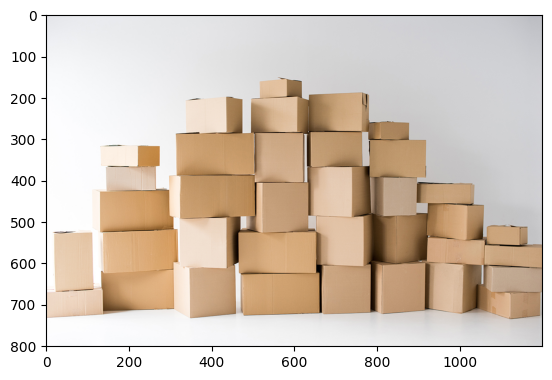

In [31]:
# prompt: show image

import matplotlib.pyplot as plt
plt.imshow(image)
plt.show()


In [33]:
type(image)


torch.Tensor

In [35]:
image.shape

torch.Size([801, 1200, 3])

In [40]:
reshaped_image = image.permute(2, 0, 1)

In [44]:
model

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [42]:
model = model.to("cuda")
reshaped_image = reshaped_image.to("cuda")

In [110]:
import torch
import torchvision.transforms as transforms
from PIL import Image

# Preprocess the image
def preprocess_image(image_path):
    image = Image.open(image_path)
    transform = transforms.Compose([
        # transforms.Resize((224, 224)),  # Adjust size as needed
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Adjust normalization parameters if needed
    ])
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    return image

# Run inference
def run_inference(model, image):
    model.eval()
    with torch.no_grad():
        output = model(image)
    return output


In [122]:
# Example usage
# image_path = '/content/new_image.jpg'
image_path = "/content/gdrive/MyDrive/box_img.png"
preprocessed_image = preprocess_image(image_path).to("cuda")
output = run_inference(model, preprocessed_image)

In [123]:
# Get keys
keys = output.keys()
print("Keys:", keys)

Keys: odict_keys(['out', 'aux'])


In [124]:
# Get values
values = output.values()
print("Values:", values)

Values: odict_values([tensor([[[[ 0.6515,  0.6515,  0.6515,  ...,  0.6528,  0.6528,  0.6528],
          [ 0.6515,  0.6515,  0.6515,  ...,  0.6528,  0.6528,  0.6528],
          [ 0.6515,  0.6515,  0.6515,  ...,  0.6528,  0.6528,  0.6528],
          ...,
          [ 0.5734,  0.5734,  0.5734,  ..., -0.0079, -0.0079, -0.0079],
          [ 0.5734,  0.5734,  0.5734,  ..., -0.0079, -0.0079, -0.0079],
          [ 0.5734,  0.5734,  0.5734,  ..., -0.0079, -0.0079, -0.0079]]]],
       device='cuda:0'), tensor([[[[ 9.7353,  9.7353,  9.7353,  ...,  9.8105,  9.8105,  9.8105],
          [ 9.7353,  9.7353,  9.7353,  ...,  9.8105,  9.8105,  9.8105],
          [ 9.7353,  9.7353,  9.7353,  ...,  9.8105,  9.8105,  9.8105],
          ...,
          [ 9.4168,  9.4168,  9.4168,  ...,  6.3061,  6.3061,  6.3061],
          [ 9.4168,  9.4168,  9.4168,  ...,  6.3061,  6.3061,  6.3061],
          [ 9.4168,  9.4168,  9.4168,  ...,  6.3061,  6.3061,  6.3061]],

         [[-0.6217, -0.6217, -0.6217,  ..., -1.2540, -

In [125]:
out_output = output["out"]
out_output.shape

torch.Size([1, 1, 1024, 1024])

In [126]:
out_output_0 = out_output[0]
out_output_0.shape


torch.Size([1, 1024, 1024])

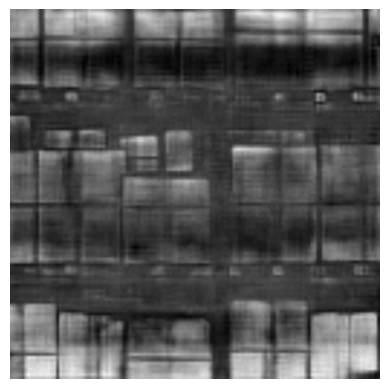

In [127]:
# Convert tensor to NumPy array and remove batch dimension
out_output_0 = out_output_0.cpu()
array = out_output_0.squeeze().numpy()

# Plot the NumPy array
plt.imshow(array, cmap='gray')  # Plot as grayscale
plt.axis('off')  # Turn off axis
plt.show()

In [128]:
preprocessed_image = preprocessed_image.cpu()

In [129]:
preprocessed_image = preprocessed_image[0]

In [130]:
preprocessed_image= preprocessed_image

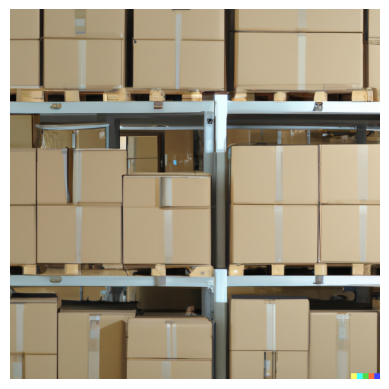

In [131]:
# Convert tensor to NumPy array and reorder dimensions
array = preprocessed_image.permute(1, 2, 0).numpy()

# Plot the NumPy array
plt.imshow(array)
plt.axis('off')
plt.show()